### **Análise de dados sobre a ocorrência de doenças cardiovasculares**

Esse projeto possui como objetivo trabalhar com o conjunto de dados sobre doenças cardíacas do site Kaggle: [Cardiovascular Disease Dataset](https://www.kaggle.com/sulianova/cardiovascular-disease-dataset). 

As seguintes tarefas foram realizadas:


*   Análise inicial dos dados;
*   Processo de *feature engineering*;
*   Análise de correlação e seleção das *features* mais relevantes para o treino;
*   Utilização da biblioteca *Pytorch* para criar um modelo de aprendizado supervisionado;
*   Análise do resultado proporcionado pelo modelo.


Obs: esse projeto é consistente com o aprendizado adquirido até o dia 31 / 09 / 2020. Após essa data novos conhecimentos serão adquiridos e algumas decisões de projeto provavelmente mudariam.  

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Descrição dos dados:

*   Coluna 1: Idade em dias (inteiro)
*   Coluna 2: Altura em cm (inteiro)
*   Coluna 3: Peso em kg (float)
*   Coluna 4: Gênero (dado categórico)
*   Coluna 5: Pressão sanguínea sistólica (inteiro)
*   Coluna 6: Pressão sanguínea diastólica (inteiro)
*   Coluna 7: Colesterol (1 - normal; 2 - acima do normal; 3 muito acima do normal)
*   Coluna 8: Glicose (1 - normal; 2 - acima do normal; 3 muito acima do normal)
*   Coluna 9: Consumo de cigarro (1 - Sim ; 0 - Não)
*   Coluna 10: Consumo de álcool (1 - Sim ; 0 - Não)
*   Coluna 11: Realiza atividade física (1 - Sim ; 0 - Não)
*   Coluna 12: Presença ou ausência de doença cardiovascular (1 - Sim ; 0 - Não)



















In [ ]:
import pandas as pd
import numpy as np
from seaborn import heatmap
from seaborn import barplot
from pandas import Series, concat
dados = pd.read_csv("/content/drive/My Drive/Colab Notebooks/cardio_train.csv", sep=";")

#removendo a coluna id que é irrelevante para a análise
dados_drop = dados.drop(columns=["id"])
dados_drop


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69995,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [ ]:
#Vamos checar o balanceamento dos True Negativos (Não tem doença cardíaca) e True Positivos (tem doença cardíaca do dataset)
positivo = 0
negativo = 0
for i in dados_drop['cardio']:
  if(dados_drop['cardio'][i] == 1):
    positivo += 1
  elif(dados_drop['cardio'][i] == 0):
    negativo += 1
  else:
    print("ERRO NO LABEL DO DATASET")

print("POSITIVO: ", positivo)
print("NEGATIVO: ", negativo)

POSITIVO:  34979
NEGATIVO:  35021


Para uma análise extra e treinar a manipulação dos dados, vamos realizar um *feature engineering* e medir o índice de massa corporal de cada um dos indivíduos. Não se trata de uma medida ideal pois provavelmente um indicador da porcentagem de gordura corporal traria melhores resultados, porém é uma análise válida que pode ser feita. O cálculo do IMC é dado por:

$$IMC = \frac{Peso}{Altura^2}$$

Onde a altura é calculada em metros e o peso em kg. 

In [ ]:
altura_quadrado = (dados_drop["height"]/100)*(dados_drop["height"]/100)
peso = dados_drop["weight"]
imc = peso/altura_quadrado
imc

0        21.967120
1        34.927679
2        23.507805
3        28.710479
4        23.011177
           ...    
69995    26.927438
69996    50.472681
69997    31.353579
69998    27.099251
69999    24.913495
Length: 70000, dtype: float64

Transformando a idade de dias para anos. Para trabalhar com valores menores, diminuindo a computação necessária.

In [ ]:
idade_nova = dados_drop["age"]/365

Vamos agora fazer um append dos valores de IMC e idade no dataframe original.


In [ ]:
dados_drop["imc"]=imc
dados_drop["age"]=idade_nova
dados_drop

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,imc
0,50.391781,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,55.419178,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,51.663014,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,48.282192,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,47.873973,1,156,56.0,100,60,1,1,0,0,0,0,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,52.712329,2,168,76.0,120,80,1,1,1,0,1,0,26.927438
69996,61.920548,1,158,126.0,140,90,2,2,0,0,1,1,50.472681
69997,52.235616,2,183,105.0,180,90,3,1,0,1,0,1,31.353579
69998,61.454795,1,163,72.0,135,80,1,2,0,0,0,1,27.099251


Para fazer uma análise da relação dos dados com o output, vamos separar os dados categóricos dos dados numéricos. 

In [ ]:
features_categoricas = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']
categorical_data = dados_drop[features_categoricas]
categorical_data


,gender,cholesterol,gluc,smoke,alco,active,cardio
0,2,1,1,0,0,1,0
1,1,3,1,0,0,1,1
2,1,3,1,0,0,0,1
3,2,1,1,0,0,1,1
4,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...
69995,2,1,1,1,0,1,0
69996,1,2,2,0,0,1,1
69997,2,3,1,0,1,0,1
69998,1,1,2,0,0,0,1


In [ ]:
features_numericas = ['age', 'height', 'weight','imc', 'ap_hi', 'ap_lo', 'cardio']
numerical_data = dados_drop[features_numericas]
numerical_data

,age,height,weight,imc,ap_hi,ap_lo,cardio
0,50.391781,168,62.0,21.967120,110,80,0
1,55.419178,156,85.0,34.927679,140,90,1
2,51.663014,165,64.0,23.507805,130,70,1
3,48.282192,169,82.0,28.710479,150,100,1
4,47.873973,156,56.0,23.011177,100,60,0
...,...,...,...,...,...,...,...
69995,52.712329,168,76.0,26.927438,120,80,0
69996,61.920548,158,126.0,50.472681,140,90,1
69997,52.235616,183,105.0,31.353579,180,90,1
69998,61.454795,163,72.0,27.099251,135,80,1


Vamos agora fazer a análise da correlação com os dados numéricos.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe939f35080>],
      dtype=object)

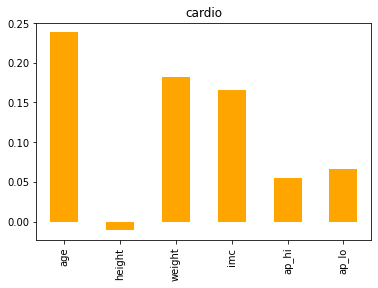

In [615]:
#Vamos criar um gráfico de barras para analisar a correlação das features com o label
#Para a correlação, utilizaremos o método de pearson
cor_pearson = numerical_data.corr(method='pearson')
#Dropando o cardio, pois ele tem uma relação de 1 para 1 com o cárdio
cor_pearson = cor_pearson.drop('cardio')
#Plotando um gráfico de barras com a correlação
cor_pearson['cardio'].plot.bar(subplots=True, color = 'orange')

Analisando a correlação dos demais atributos com o atributo "cardio", podemos concluir que a altura pouco influência na ocorrência de uma pessoa ter uma doença cardíaca, já o peso, idade e pressão cardíaca sistólica e diastólica possuem influências maiores nessa ocorrência. Assim, reduziremos o número de atributos para acelerar o treino, mantendo os atributos "age", "weight", "ap_hi" e "ap_lo" (o atributo imc criado mostrou não ser uma grande influência, pois depende da altura, que possui uma baixa correlação - inclusive negativa -  com a ocorrência de doenças cardíacas). 

Mesmo que o atributo IMC não seja tão relevante, realizaremos dois treinos, um mantendo os atributos descritos anteriormente (com o peso em kg), e outro com o IMC no lugar do peso, para comparar os resultados.   

Agora precisamos transformar os dados categóricos em representações one-hot, para podermos fazer análises da relevância dos dados.

In [ ]:
#transformando cada um dos dados categóricos em representações one-hot
categorical_data = pd.concat([categorical_data, pd.get_dummies(categorical_data['gender'], prefix='gender')], axis = 1)
categorical_data = pd.concat([categorical_data, pd.get_dummies(categorical_data['cholesterol'], prefix='cholesterol')], axis = 1)
categorical_data = pd.concat([categorical_data, pd.get_dummies(categorical_data['gluc'], prefix='gluc')], axis = 1)
categorical_data = pd.concat([categorical_data, pd.get_dummies(categorical_data['cardio'], prefix='cardio')], axis = 1)

#removendo as colunas originais, pois foram substituidas pela representação one-hot
categorical_data = categorical_data.drop(columns=['gender', 'cholesterol', 'gluc'])


categorical_data


,smoke,alco,active,cardio,gender_1,gender_2,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3,cardio_0,cardio_1
0,0,0,1,0,0,1,1,0,0,1,0,0,1,0
1,0,0,1,1,1,0,0,0,1,1,0,0,0,1
2,0,0,0,1,1,0,0,0,1,1,0,0,0,1
3,0,0,1,1,0,1,1,0,0,1,0,0,0,1
4,0,0,0,0,1,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,1,0,1,0,0,1,1,0,0,1,0,0,1,0
69996,0,0,1,1,1,0,0,1,0,0,1,0,0,1
69997,0,1,0,1,0,1,0,0,1,1,0,0,0,1
69998,0,0,0,1,1,0,1,0,0,0,1,0,0,1


Para encontrar as variáveis categóricas mais importantes, não podemos utilizar diretamente a correlação de Pearson, assim utilizaremos o método **Feature Importance**. Ele  fornece uma pontuação para cada variável do conjunto de dados, sendo que quanto maior a pontuação, mais importante ou relevante é aquela variável para a saída, havendo uma maior relação.
Esse método é uma classe embutida que vem com classificadores baseados em árvores de decisão, logo usaremos o Extra Tree Classifier para extrair os 10 principais recursos para o conjunto de dados.

[1.38540918e-05 6.51668040e-06 1.15584821e-04 3.07817743e-01
 2.04065889e-05 1.56292595e-05 6.41812240e-03 7.11423602e-04
 3.27346012e-03 5.40928148e-04 7.57767915e-05 1.44928740e-04
 2.94418318e-01 3.86427307e-01]


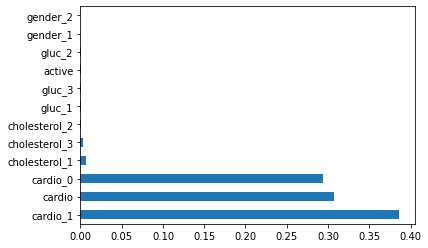

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(categorical_data, categorical_data["cardio"])
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=categorical_data.columns)
feat_importances.nlargest(12).plot(kind='barh')

In [ ]:
#selecionando as features mais importantes em ordem descrescente de importância
final_features = []
for index, _ in feat_importances.nlargest(10).iteritems():
  final_features.append(index)

print(final_features)

['cardio_1', 'cardio', 'cardio_0', 'cholesterol_1', 'cholesterol_3', 'cholesterol_2', 'gluc_1', 'gluc_3', 'active', 'gluc_2']


Neste caso, podemos perceber que as features relacionadas ao hábito de fumar, hábito de beber, atividade física e gênero não possuem tanta influência para gerar uma doença cardíaca. Por isso removerei tais features do treino. 

Separando agora os dados de treino e teste, retirando as features que não serão utilizadas no treino. Faremos duas análises e treinamentos, uma considerando somente o peso dos indivíduos e não o IMC e a outra considerando apenas o IMC e não o peso. Para realizar o treinamento, utilizaremos $85\%$ dos dados para treinamento e $15\%$ dos dados para teste. 

In [ ]:
#Dados para o treino considerando o Peso
aux1 = numerical_data[["age", "weight", "ap_hi", "ap_lo"]]
aux2 = categorical_data[["cholesterol_1", "cholesterol_2", "cholesterol_3", "gluc_1", "gluc_2", "gluc_3", "cardio_0", "cardio_1"]]
aux3 = pd.concat([aux1, aux2], axis=1)

train_weight_x, train_weight_y = aux3.iloc[0:60000, 0:10], aux3.iloc[0:60000, 10:12]
test_weight_x, test_weight_y = aux3.iloc[60000: 70000, 0:10], aux3.iloc[60000: 70000, 10:12]


#Dados para o treino considerando o IMC
aux1 = numerical_data[["age", "imc", "ap_hi", "ap_lo"]]
aux2 = categorical_data[["cholesterol_1", "cholesterol_2", "cholesterol_3", "gluc_1", "gluc_2", "gluc_3", "cardio_0", "cardio_1"]]
aux3 = pd.concat([aux1, aux2], axis=1)

train_imc_x, train_imc_y = aux3.iloc[0:60000, 0:10], aux3.iloc[0:60000, 10:12]
test_imc_x, test_imc_y = aux3.iloc[60000:70000, 0:10], aux3.iloc[60000:70000, 10:12]



Agora vamos finalmente para o treino :)

Primeiramente, vamos criar nosso modelo de análise. Para este problema, foi escolhida uma Multi-Layer Perceptron para realizar a classificação.

A arquitetura usada pela rede foi:

BATCH_SIZE = 1024

EPOCHS = 100

LEARNING_RATE = 0.005

Isso significa que o conjunto de dados será dividido em lotes de 1024, e todos esses lotes gerados serão treinados 100 vezes (1 época = percorrer uma vez todo o conjunto de dados no treino). O learning rate foi definido como 0.005 pois foi o valor que performou de forma mais satisfatória após a análise de diferentes valores. 

In [608]:
#Definindo o modelo da rede
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class Cardio_Model(nn.Module):
  def __init__(self):
    super(Cardio_Model, self).__init__()

    self.fc1 = nn.Linear(10, 8)
    self.fc2 = nn.Linear(8, 6)
    self.fc3 = nn.Linear(6, 2)

  def forward(self, x):
    x = F.tanh(self.fc1(x))
    x = F.relu(self.fc2(x))

    return F.sigmoid(self.fc3(x))

#Testando a rede
model = Cardio_Model()
model

Cardio_Model(
  (fc1): Linear(in_features=10, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=6, bias=True)
  (fc3): Linear(in_features=6, out_features=2, bias=True)
)

Criando agora o modelo de treino.

In [609]:
#Definindo Variáveis e Hiperparâmetros
BATCH_SIZE = 1024
EPOCHS = 100
LEARNING_RATE = 0.005
print_results = 60000

#Criando o modelo
cardio_model = Cardio_Model()

#Setando o optimizador e a loss function
optimizer = torch.optim.Adam(params=cardio_model.parameters(), lr=LEARNING_RATE)
loss_function = nn.BCELoss()

In [610]:
tensor_x = torch.tensor(train_weight_x.values, dtype=torch.float32)
tensor_y = torch.tensor(train_weight_y.values, dtype=torch.float32)

In [611]:
dl_train_weight_x = torch.utils.data.DataLoader(tensor_x, batch_size=BATCH_SIZE)
dl_train_weight_y = torch.utils.data.DataLoader(tensor_y, batch_size=BATCH_SIZE)

In [ ]:
#Guarda a loss ao longo das épocas para posteriormente plotar seu gráfico
loss_over_epochs = []

#Treinando o modelo
for epoch in range(EPOCHS):
  #Carregando os iteradores de batch
  iter_x = iter(dl_train_weight_x)
  iter_y = iter(dl_train_weight_y)

  for i in range(0, len(train_weight_x), BATCH_SIZE):

    #Alocando batch do iterador
    batch_X = iter_x.next()
    batch_y = iter_y.next()

    #Zerando a loss function para não acumular
    cardio_model.zero_grad()

    #Forward Prop
    outputs = cardio_model(batch_X)

    #Calculando a loss
    loss = loss_function(outputs, batch_y)
    #Backward Prop
    loss.backward()

    #Atualizando os pesos
    optimizer.step()

    if i % print_results == 0:
      #Printando perda e informações
      loss_over_epochs.append(loss.item())
      print("Train Epoch: ", epoch, "   LOSS: ", loss.item())

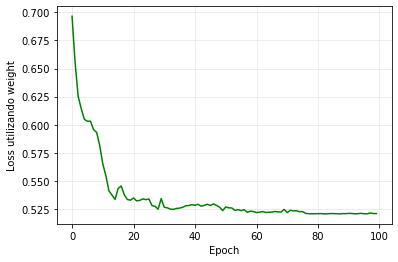

In [613]:
#Plotando a Loss
import matplotlib.pyplot as plt

plt.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)
plt.plot(loss_over_epochs, color='g', linewidth=1.5)

plt.ylabel("Loss utilizando weight")
plt.xlabel("Epoch")

plt.show()



Agora vamos avaliar medidas de desempenho do nosso modelo.

In [614]:
correct = 0
total = 0


#Carregando os iteradores de batch
iter_x = iter(dl_test_weight_x)
iter_y = iter(dl_test_weight_y)

with torch.no_grad():
  for i in tqdm(range(len(test_weight_x))):

    #Alocando batch do iterador
    batch_X = iter_x.next()
    batch_y = iter_y.next()

    real_class = torch.argmax(batch_y)
    net_out = cardio_model(batch_X)
    
    predicted_class = torch.argmax(net_out)

    if(predicted_class == real_class):
      correct += 1
    total += 1

  print("Accuracy: ", correct/total*100)

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 10000/10000 [00:01<00:00, 6172.31it/s]

Accuracy:  72.6


Conseguimos então uma acurácia de quase 72.6%. Comparando com outros notebooks do kaggle sobre esse conjunto de dados, resultados similares foram alcançados. 